In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%watermark --iversions

pandas  0.18.1
pytz    2016.6.1
numpy   1.11.1
zipline v1.3.0
pyfolio 0.9.2



# 2. Загрузка данных

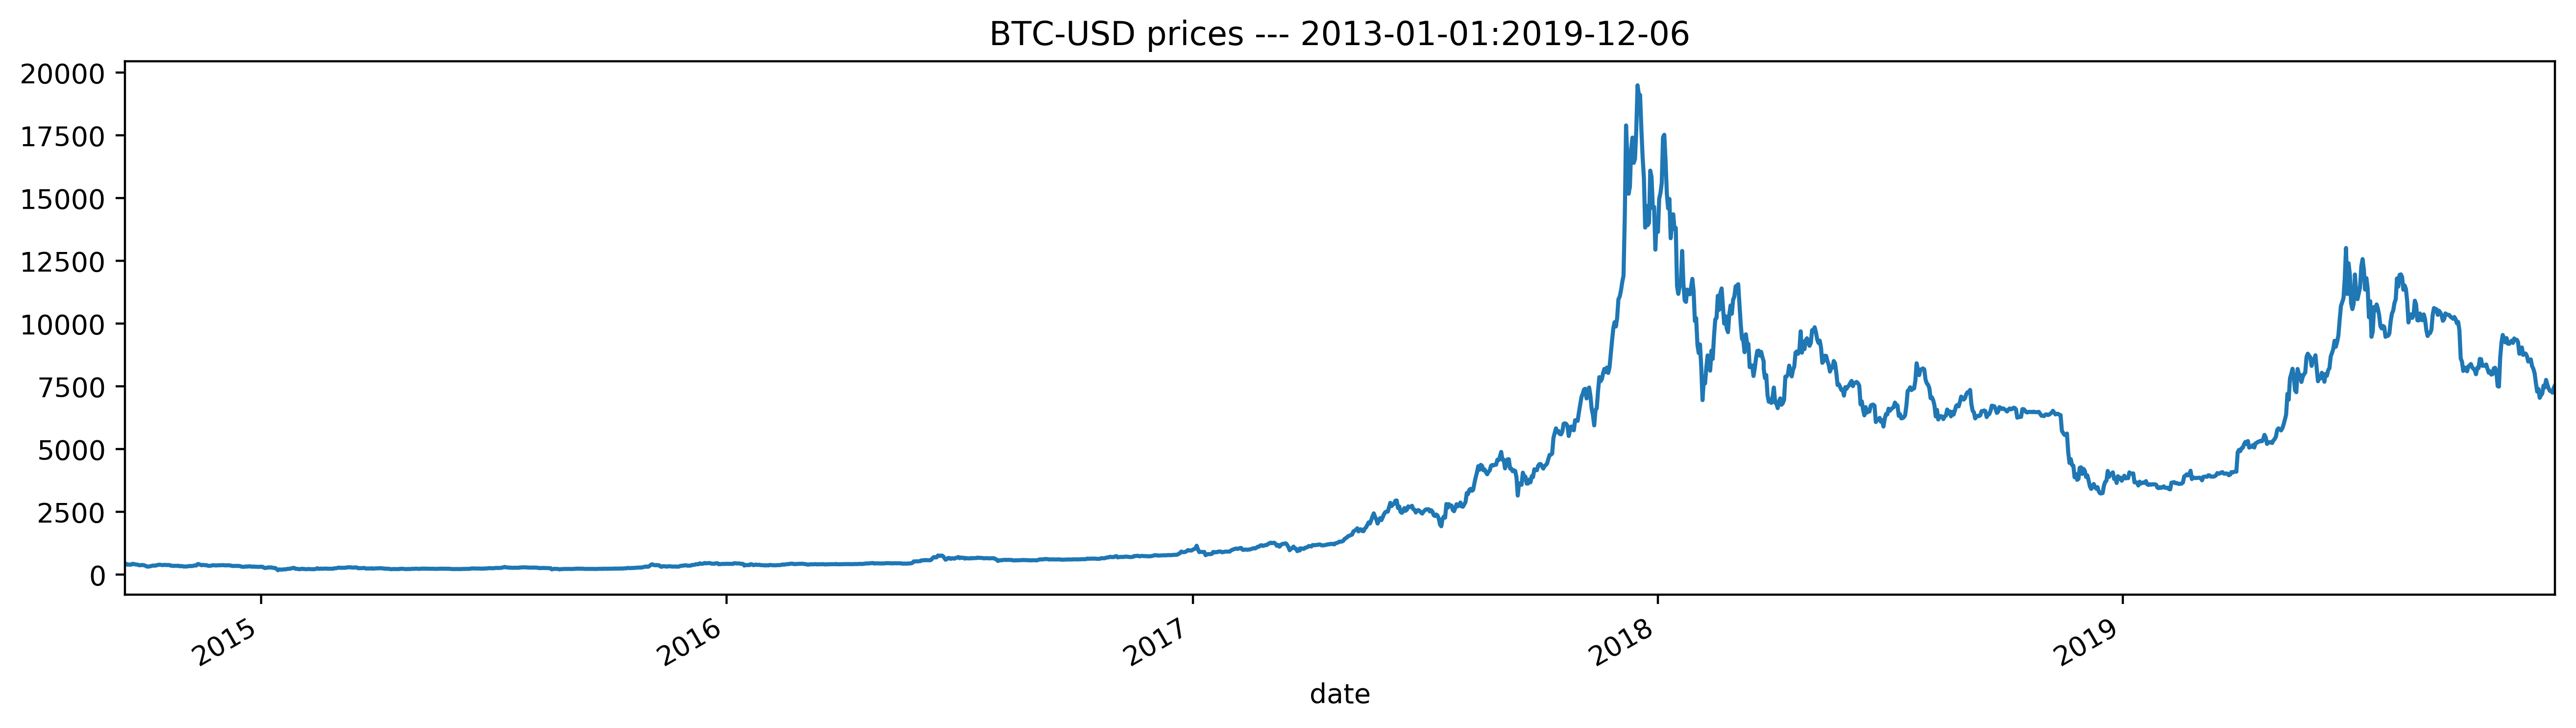

In [5]:
qf.download_csv_data(ticker='BTC-USD', 
                  start_date='2013-01-01', 
                  end_date='2019-12-06', 
                  freq='daily', 
                  path='data/BTC.csv')

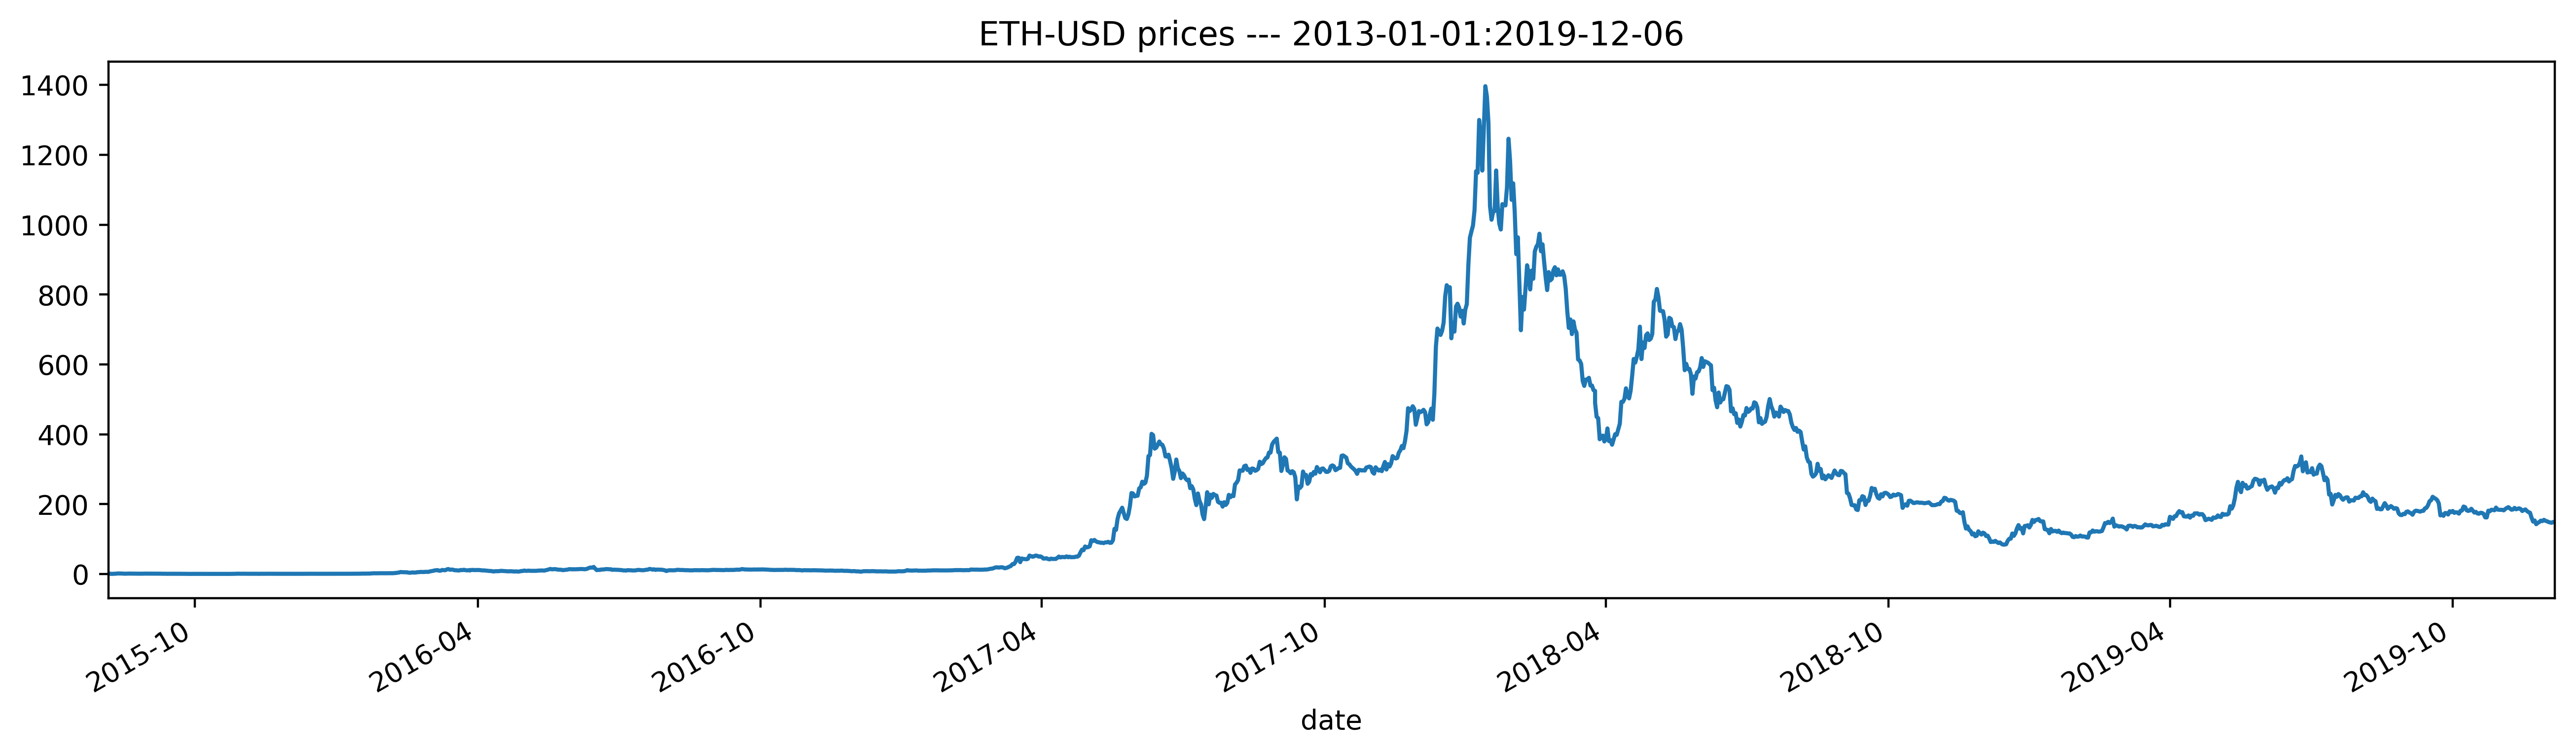

In [6]:
qf.download_csv_data(ticker='ETH-USD', 
                  start_date='2013-01-01', 
                  end_date='2019-12-06', 
                  freq='daily', 
                  path='data/ETH.csv')

# 3. Strategy with fix rebalance period and deferred purchase

## Формируем данные для анализа стратегии

In [7]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'high', 'low', 'close', 'volume']

In [8]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                  open        high         low       close      volume
date                                                                  
2014-09-16  465.864014  468.174011  452.421997  457.334015  21056800.0
2014-09-17  456.859985  456.859985  413.104004  424.440002  34483200.0
2014-09-18  424.102997  427.834991  384.532013  394.795990  37919700.0
2014-09-19  394.673004  423.295990  389.882996  408.903992  36863600.0
2014-09-20  408.084991  412.425995  393.181000  398.821014  26580100.0
                open      high       low     close     volume
date                                                         
2015-08-06  2.831620  3.536610  2.521120  2.772120   164329.0
2015-08-07  2.793760  2.798810  0.714725  0.753325   674188.0
2015-08-08  0.706136  0.879810  0.629191  0.701897   532170.0
2015-08-09  0.713989  0.729854  0.636546  0.708448   405283.0
2015-08-10  0.708087  1.131410  0.663235  1.067860  1463100.0


## Приводим данные к одинаковой длинне

In [9]:
for tiker in TIKERS:
    if tiker == 'BTC':
        continue
    else:
        tmp = data['BTC'].copy()
        for column in COLUMNS:
            tmp[column] = 0    

        # удаляем лишнее
        tmp = tmp.iloc[:(len(tmp)-len(data[tiker]))]

        # Вносим данные
        tmp = tmp.append(data[tiker], ignore_index = False)
        data[tiker] = tmp

In [10]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1908 (major_axis) x 5 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2014-09-16 00:00:00+00:00 to 2019-12-06 00:00:00+00:00
Minor_axis axis: open to volume


## Определяем параметры и функции алгоритма

In [11]:
WEIGHTS = [[0.8, 0], [0.55, 0.25]]
ASSETS_START = [date(2016, 10, 1)]
ORDER_MAX = 0.001
COMMISSION = 0.0007

In [12]:
ORDER_FINISHED_FLAG = []
START_BUY_DAY_FLAG = []
for i in range(len(panel)):
    ORDER_FINISHED_FLAG.append(False)
    START_BUY_DAY_FLAG.append(True)

In [13]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.stage = 0
    
    context.assets_start = ASSETS_START
    
    context.order_max = ORDER_MAX
    
    context.order_finished_flag = ORDER_FINISHED_FLAG
    
    context.rebalance_period = 90
    context.time = 0
    
    context.start_buy_day_flag = START_BUY_DAY_FLAG

In [14]:
def asset_chek(context, day, n):
    
    # Проверка начала закупки
    if day == context.assets_start[n]:
        context.stage = n + 1
        context.time = 0
        
        # Обнуляем флаги сигнализируещие о завершении ордера 
        # логика в том, что когда подключается новый актив, веса других активов меняются, следовательно нужны ордеры
        for i, flag in enumerate(context.order_finished_flag):
            context.order_finished_flag[i] = False

In [15]:
def start_buying_check(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    
    # проверяем каждый актив
    for i in range(0, context.n_assets -1):
        asset_chek(context, day, i)

In [16]:
def orders(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    
    
    # Вычисляем потенциальное изменение веса каждого актива
    for i, asset in enumerate(context.assets):
         
        #print('Входим в дневном цикле в актив', asset, context.order_finished_flag)    
            
        volume = data.current(asset, 'volume')
        price = data.current(asset, 'price')
            
        # Проверка на актив, заданный вес которого равен 0
        target_weight = context.weights[context.stage][i]
        #print('Целевой вес =', target_weight, asset)
        
        if target_weight == 0:
            context.order_finished_flag[i] = True
            #print('Изменение статуса актива', asset, context.order_finished_flag)
            continue
            
            
        # Проверяем стоит ли рассматривать данный актив или уже ордер был сделан
        if context.order_finished_flag[i] == False:
            
            if context.start_buy_day_flag[i] == True:
                current_weight = 0
                context.start_buy_day_flag[i] = False
            else: 
                current_weight = context.portfolio.current_portfolio_weights.get(key = asset)
            
            #print('Текущий вес актива =', current_weight, asset)


            # Продажа актива
            if current_weight > target_weight:
                    
                # Проверка ограничения по объему
                potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value

                weight_change = current_weight - target_weight

                if potential_weight_change >= weight_change:

                    # Полностью реализуем целевой вес актиа
                    order_target_percent(asset, target_weight)
                    context.order_finished_flag[i] = True
                    #print(prices.index[0].date(), ' - Продажа завершена', asset)
                else:
                        
                    # Частично продаем приводя текущий вес ближе к целевому
                    available_weight = current_weight - potential_weight_change
                    order_target_percent(asset, available_weight)
                    #print(prices.index[0].date(), ' - Частичная продажа', asset)
                        
            # Покупка активов
            if current_weight < target_weight:
                    
                    
                # Проверка ограничения по объему
                volume_potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value
                    
                # Проверка ограничения по количеству наличных
                cash_potential_weight_change = context.portfolio.cash * 0.99/context.portfolio.portfolio_value
                    
                # потенциальное изменение веса равна меньшуму из двух ограничений
                potential_weight_change = 0
                if volume_potential_weight_change > cash_potential_weight_change:
                    potential_weight_change = cash_potential_weight_change
                else:
                    potential_weight_change = volume_potential_weight_change
                    
                    
                weight_change = target_weight - current_weight 

                if potential_weight_change > weight_change:

                    # Полностью реализуем целевой вес актиа
                    order_target_percent(asset, target_weight)
                    context.order_finished_flag[i] = True
                    #print(prices.index[0].date(), ' - Закупка завершена',asset)

                else:
                    # Частично покупаем приводя текущий вес ближе к целевому
                    available_weight = current_weight + potential_weight_change
                    order_target_percent(asset, available_weight)
                    #print(prices.index[0].date(), ' - Частичная закупка', asset)
                
                
    # Считаем количество завершенных закупок
    verification = 0
    for i in context.order_finished_flag:
        if i == True:
            verification += 1
        
    # Если все закупка/ребаллансировка завершена, начинаем отсчет дней до ребаллансировки
    if verification == len(context.order_finished_flag):
        context.time += 1
        #print(prices.index[0].date(), ' - Закупка/ребаллансировка портфеля закончена')
            
        # Обнуляем флаги сигнализируещие о завершении ордера
        for i, flag in enumerate(context.order_finished_flag):
            context.order_finished_flag[i] = False

In [17]:
def handle_data(context, data):
    
    prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
    day = prices.index[0].date()
    #print(day)
    
    # Проверка начала закупки акивов (меняем веса активов и обнуляем context.time)   DONE
    start_buying_check(context, data)    
    
    
    # Когда context.time = 0 - закупка, когда context.time кратно периоду ребаллансировки - ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):     
    
        orders(context, data)
    
    else:
        context.time += 1

In [18]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 1, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              trading_calendar=AlwaysOpenCalendar(),
                              capital_base=1000000,
                              handle_data=handle_data,
                              data=panel)

In [19]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [20]:
qf.get_performance_summary(returns)

annual_volatility      0.510650
annualized_returns     0.764038
cumulative_returns    33.727642
max_drawdown          -0.758244
sharpe_ratio           1.367188
sortino_ratio          2.084201
dtype: float64

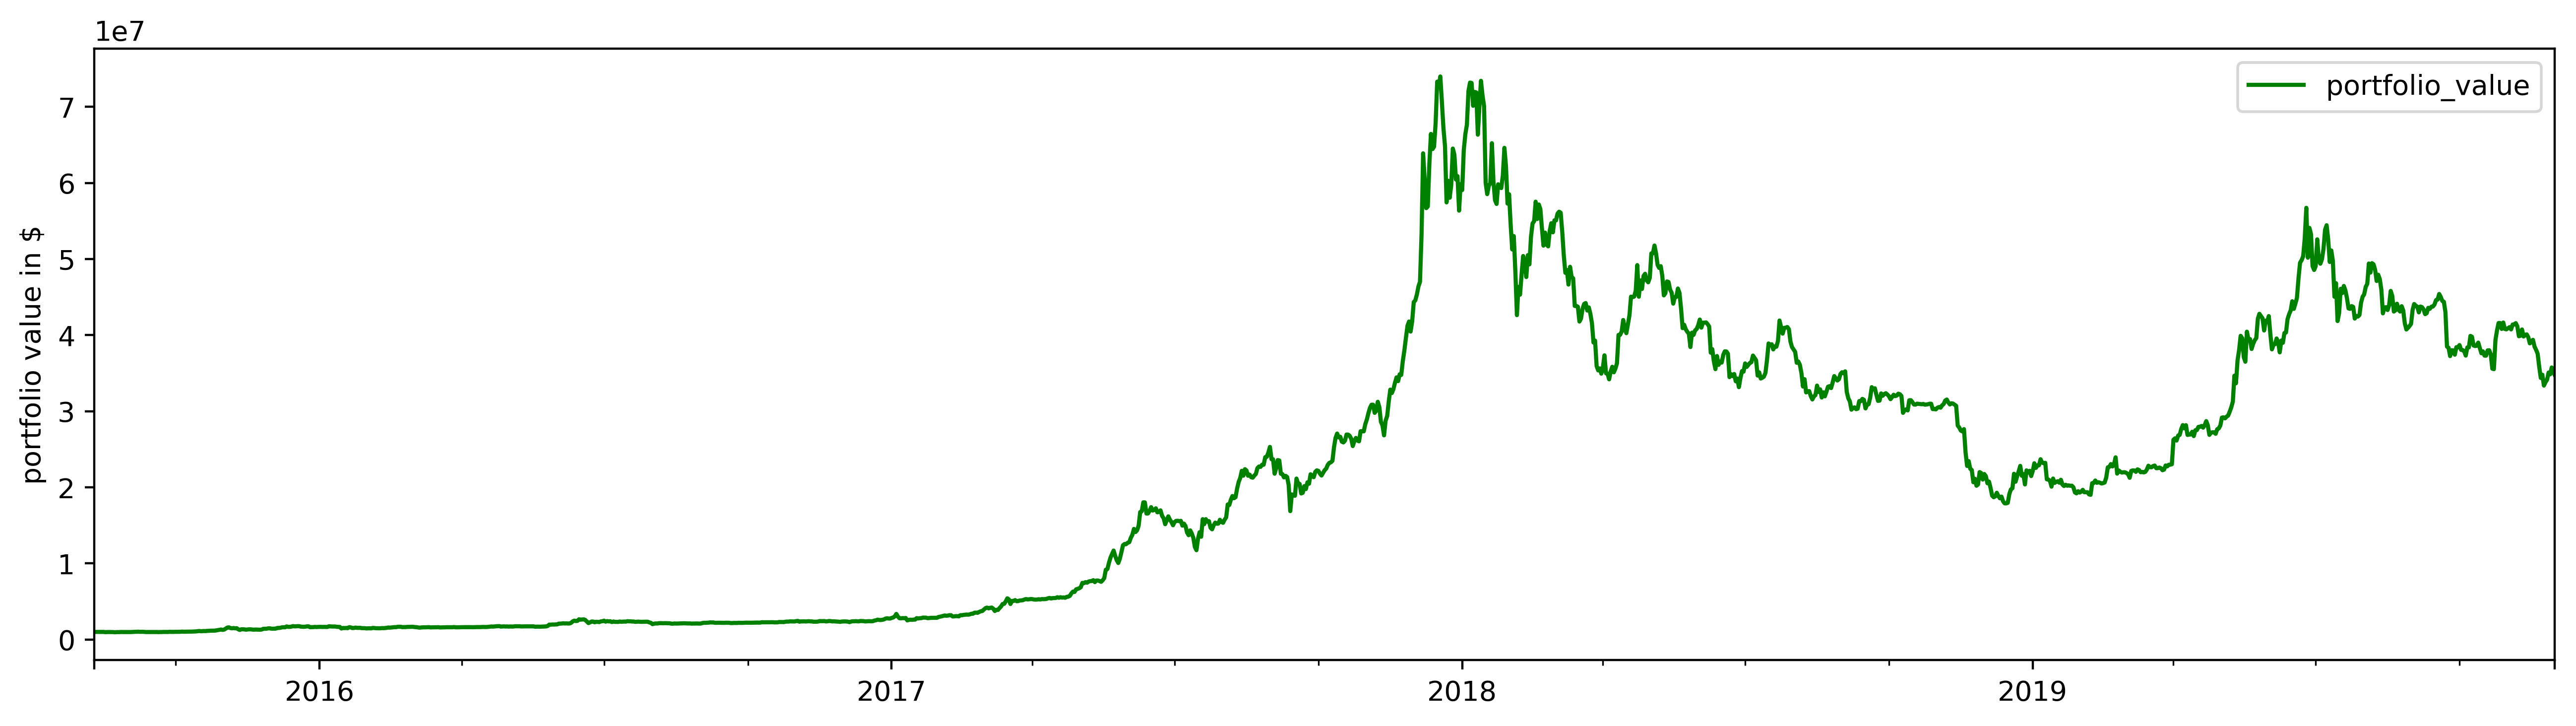

Final portfolio value (including cash): 34727641.56$


In [21]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
perf.portfolio_value.plot(color='g')
ax.set_ylabel('portfolio value in $')
ax.tick_params(axis = 'x', direction = 'out')

plt.legend()
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))

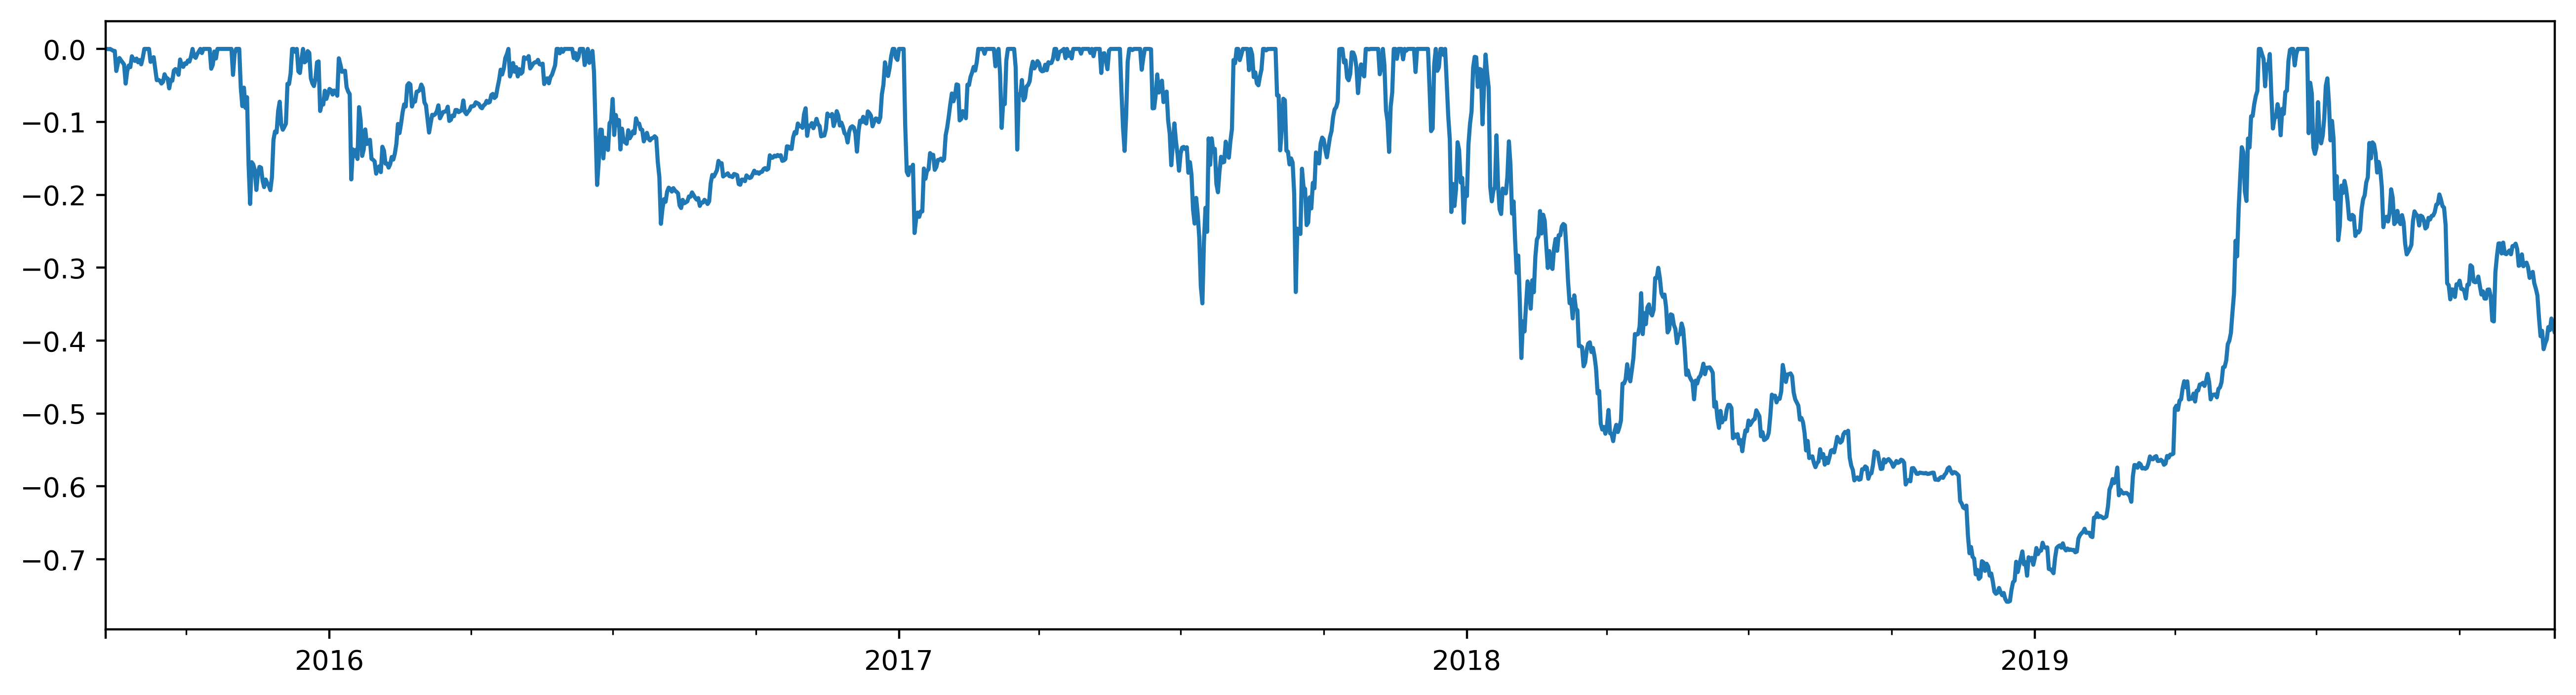

In [22]:
window = 365
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max = pd.rolling_max(perf.portfolio_value, window, min_periods=1)
Daily_Drawdown = perf.portfolio_value/Roll_Max - 1.0
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
# Plot the results
Daily_Drawdown.plot()
#Max_Daily_Drawdown.plot()
plt.show()

In [23]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

sid,Equity(0 [ETH]),Equity(1 [BTC]),cash
2019-11-27,8.892821e+06,1.749605e+07,8.694247e+06
2019-11-28,8.817674e+06,1.733680e+07,8.694247e+06
2019-11-29,9.026122e+06,1.802937e+07,8.694247e+06
2019-11-30,8.865454e+06,1.758425e+07,8.694247e+06
2019-12-01,8.786763e+06,1.724663e+07,8.694247e+06


In [24]:
# Поправляем названия столбцов

weights_df.columns = ['BTC', 'ETH', 'Cash']

In [25]:
# Нормирование весов в файле (попытка №2)

#norm_weights_df = weights_df.copy()



In [26]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])    
norm_weights_df['ETH'] = weights_df['ETH']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'])
#norm_weights_df['ICX'] = weights_df['ICX']/(weights_df['ETH'] + weights_df['BTC'] + weights_df['Cash'] + weights_df['ICX'])


In [27]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [28]:
norm_weights_df.head()

,BTC,ETH,Cash
2015-08-11,0.0,0.025040,0.974960
2015-08-12,0.0,0.051246,0.948754
2015-08-13,0.0,0.079173,0.920827
2015-08-14,0.0,0.104491,0.895509
2015-08-15,0.0,0.122321,0.877679


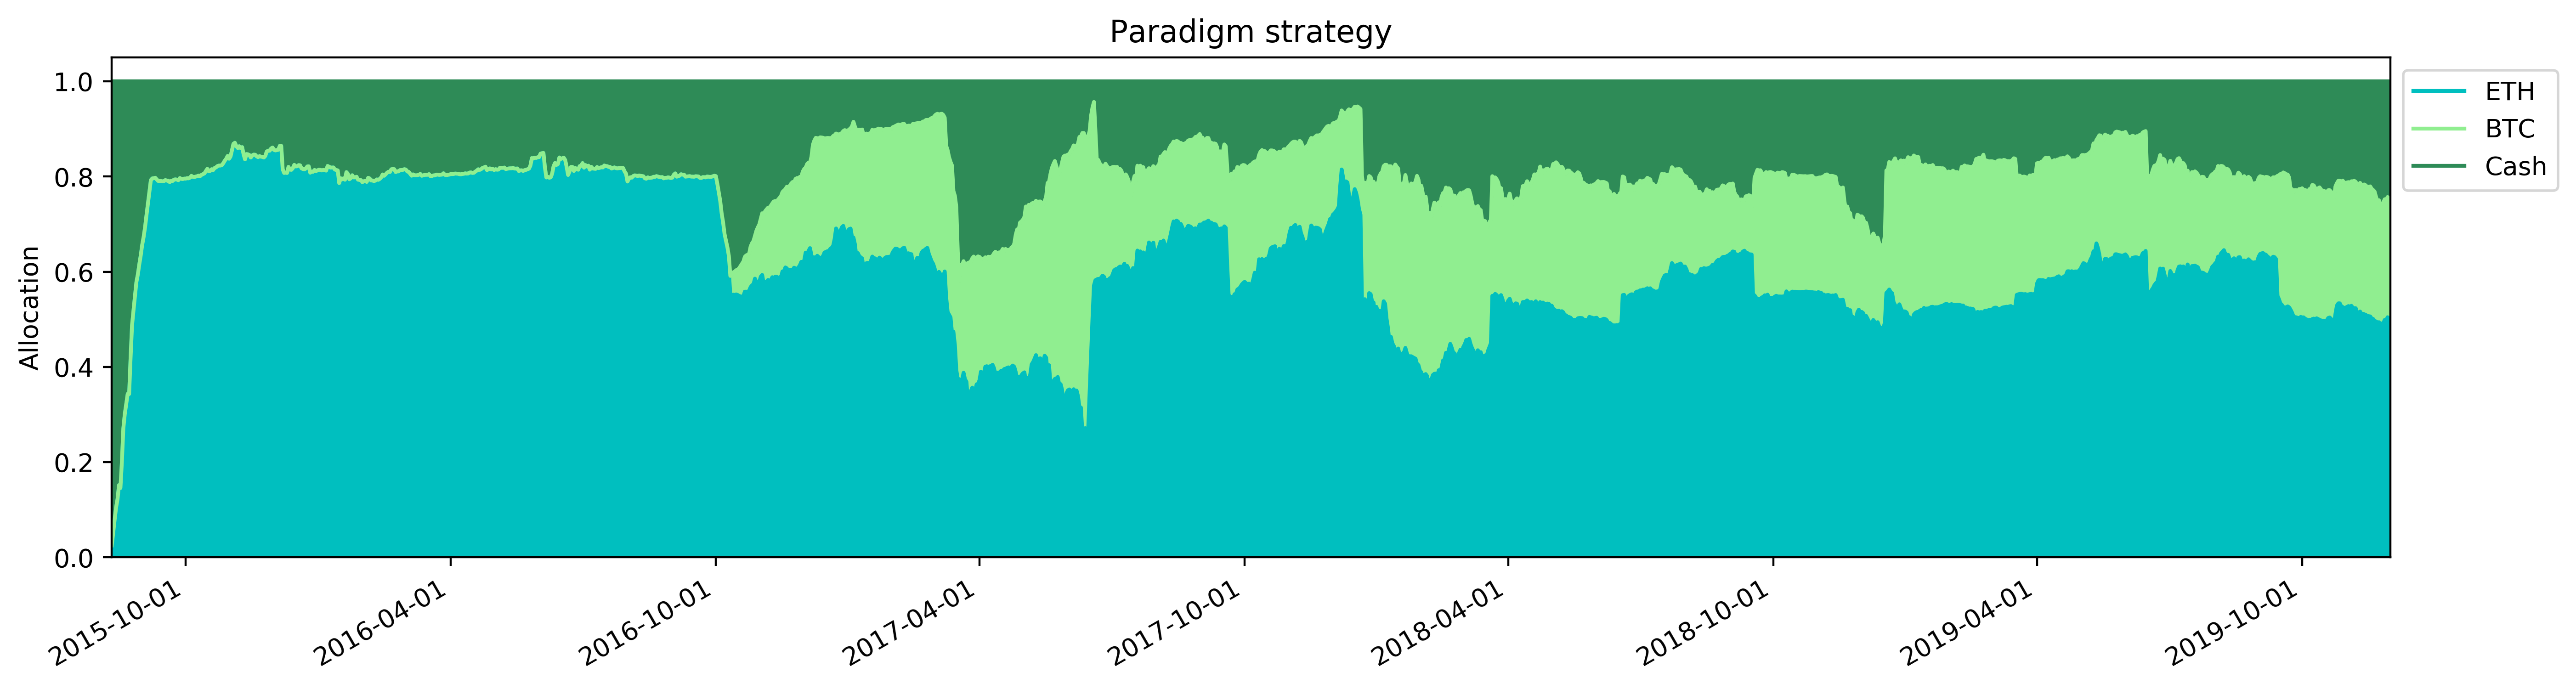

In [29]:
norm_weights_df = norm_weights_df[['ETH', 'BTC', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Влияние объемов

In [30]:
WEIGHTS = [[0.8, 0, 0], [0.55, 0.25, 0], [0.5, 0.2, 0.1]]
ASSETS_START = [date(2016, 11, 1), date(2017, 11, 1)]
COMMISSION = 0.0007
ORDER_MAX = 0.001

In [31]:
val = 10000
SIZE = []

In [ ]:
for i in range(1, 100):
    SIZE.append(val)
    val *= 1.2

In [ ]:
profit = []

for v in tqdm(SIZE):
    
    ORDER_FINISHED_FLAG = []
    START_BUY_DAY_FLAG = []
    for i in range(len(panel)):
        ORDER_FINISHED_FLAG.append(False)
        START_BUY_DAY_FLAG.append(True)
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.stage = 0

        context.assets_start = ASSETS_START

        context.order_max = ORDER_MAX

        context.order_finished_flag = ORDER_FINISHED_FLAG

        context.rebalance_period = 60
        context.time = 0

        context.start_buy_day_flag = START_BUY_DAY_FLAG
        
    def asset_chek(context, day, n):
    
        # Проверка начала закупки
        if day == context.assets_start[n]:
            context.stage = n + 1
            context.time = 0

            # Обнуляем флаги сигнализируещие о завершении ордера 
            # логика в том, что когда подключается новый актив, веса других активов меняются, следовательно нужны ордеры
            for i, flag in enumerate(context.order_finished_flag):
                context.order_finished_flag[i] = False
        
    def start_buying_check(context, data):
    
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
        day = prices.index[0].date()

        # проверяем каждый актив
        for i in range(0, 2):
            asset_chek(context, day, i)
                
    def orders(context, data):
    
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')


            # Вычисляем потенциальное изменение веса каждого актива
            for i, asset in enumerate(context.assets):

                #print('Входим в дневном цикле в актив', asset, context.order_finished_flag)    

                volume = data.current(asset, 'volume')
                price = data.current(asset, 'price')

                # Проверка на актив, заданный вес которого равен 0
                target_weight = context.weights[context.stage][i]
                #print('Целевой вес =', target_weight, asset)

                if target_weight == 0:
                    context.order_finished_flag[i] = True
                    #print('Изменение статуса актива', asset, context.order_finished_flag)
                    continue


                # Проверяем стоит ли рассматривать данный актив или уже ордер был сделан
                if context.order_finished_flag[i] == False:

                    if context.start_buy_day_flag[i] == True:
                        current_weight = 0
                        context.start_buy_day_flag[i] = False
                    else: 
                        current_weight = context.portfolio.current_portfolio_weights.get(key = asset)

                    #print('Текущий вес актива =', current_weight, asset)


                    # Продажа актива
                    if current_weight > target_weight:

                        # Проверка ограничения по объему
                        potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value

                        weight_change = current_weight - target_weight

                        if potential_weight_change >= weight_change:

                            # Полностью реализуем целевой вес актиа
                            order_target_percent(asset, target_weight)
                            context.order_finished_flag[i] = True
                            #print(prices.index[0].date(), ' - Продажа завершена', asset)
                        else:

                            # Частично продаем приводя текущий вес ближе к целевому
                            available_weight = current_weight - potential_weight_change
                            order_target_percent(asset, available_weight)
                            #print(prices.index[0].date(), ' - Частичная продажа', asset)

                    # Покупка активов
                    if current_weight < target_weight:


                        # Проверка ограничения по объему
                        volume_potential_weight_change = (volume*context.order_max)/context.portfolio.portfolio_value

                        # Проверка ограничения по количеству наличных
                        cash_potential_weight_change = context.portfolio.cash * 0.99/context.portfolio.portfolio_value

                        # потенциальное изменение веса равна меньшуму из двух ограничений
                        potential_weight_change = 0
                        if volume_potential_weight_change > cash_potential_weight_change:
                            potential_weight_change = cash_potential_weight_change
                        else:
                            potential_weight_change = volume_potential_weight_change


                        weight_change = target_weight - current_weight 

                        if potential_weight_change > weight_change:

                            # Полностью реализуем целевой вес актиа
                            order_target_percent(asset, target_weight)
                            context.order_finished_flag[i] = True
                            #print(prices.index[0].date(), ' - Закупка завершена',asset)

                        else:
                            # Частично покупаем приводя текущий вес ближе к целевому
                            available_weight = current_weight + potential_weight_change
                            order_target_percent(asset, available_weight)
                            #print(prices.index[0].date(), ' - Частичная закупка', asset)


            # Считаем количество завершенных закупок
            verification = 0
            for i in context.order_finished_flag:
                if i == True:
                    verification += 1

            # Если все закупка/ребаллансировка завершена, начинаем отсчет дней до ребаллансировки
            if verification == len(context.order_finished_flag):
                context.time += 1
                #print(prices.index[0].date(), ' - Закупка/ребаллансировка портфеля закончена')

                # Обнуляем флаги сигнализируещие о завершении ордера
                for i, flag in enumerate(context.order_finished_flag):
                    context.order_finished_flag[i] = False
                    
    def handle_data(context, data):
    
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')
        day = prices.index[0].date()
        #print(day)

        # Проверка начала закупки акивов (меняем веса активов и обнуляем context.time)   DONE
        start_buying_check(context, data)    


        # Когда context.time = 0 - закупка, когда context.time кратно периоду ребаллансировки - ребаллансировка
        if context.time == 0 or (context.time % context.rebalance_period == 0):     

            orders(context, data)

        else:
            context.time += 1
                
    perf = zipline.run_algorithm(start=datetime(2015, 8, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 12, 1, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              trading_calendar=AlwaysOpenCalendar(),
                              capital_base=v,
                              handle_data=handle_data,
                              data=panel)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
        
    profit.append(np.round(perf.portfolio_value[-1], 2))

 90%|█████████████████████████████████████████████████████████████████████████▋        | 89/99 [18:10<02:53, 17.34s/it]

In [ ]:
xlist = SIZE
ylist = profit
plt.plot(xlist, ylist)
plt.show()